In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [16]:
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0,0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)

    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        # para evitar que inicio y meta sean una pared
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1

    # ubicar en el laberinto la meta
    if meta:
        laberinto[meta] = 9
    else:
        #unicar aletoriamente si no esta especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x,y] == 0 and (x,y) != inicio:
                laberinto[x, y] = 9
                break

    return laberinto

In [17]:
def ver_laberinto(laberinto):
    plt.figure(figsize=(5,5))
    plt.imshow(laberinto, cmap="hot", interpolation = "nearest")
    plt.colorbar();

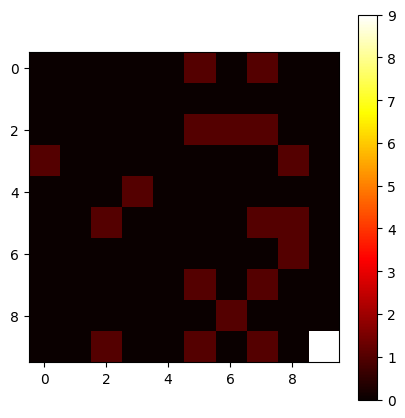

In [18]:
laberinto = crear_laberinto(10, 20, inicio=(0,0), meta=(9,9))
ver_laberinto(laberinto)

In [19]:
#parametros usados para el Q-Learning
alpha = 0.1  # Tasa de aprendizaje
gamma = 0.9  # Factor de descuento
epsilon = 0.1  # Probabilidad de exploración
num_episodios = 500  # Número de episodios para entrenar

In [20]:
# funcion para elegir acciones equilibrando entre la explotación del conocimiento y la exploracion
def epsilon_codicioso(Q, estado, tamanio_estado):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, 3)  # Suponemos 4 acciones posibles: arriba, abajo, izquierda, derecha
    else:
        return np.argmax(Q[estado])

In [21]:
# funcion para simular la accion en el laberinto
def ejecutar_accion(estado, accion, laberinto, tamanio):
    fila, columna = divmod(estado, tamanio)
    if accion == 0 and fila > 0:  # arriba
        fila -= 1
    elif accion == 1 and fila < tamanio - 1:  # abajo
        fila += 1
    elif accion == 2 and columna > 0:  # izquierda
        columna -= 1
    elif accion == 3 and columna < tamanio - 1:  # derecha
        columna += 1
    
    siguiente_estado = fila * tamanio + columna
    if laberinto[fila, columna] == 1:
        recompensa = -100  # Penalización por golpear un muro
        siguiente_estado = estado  # El agente permanece en el mismo lugar si golpea un muro
        terminado = False
    elif laberinto[fila, columna] == 9:
        recompensa = 100  # Recompensa por alcanzar el objetivo
        terminado = True
    else:
        recompensa = -1  # Penalización menor por cada paso para fomentar soluciones más rápidas
        terminado = False
    return siguiente_estado, recompensa, terminado

In [22]:
# Funcion principal para ejecutar el algoritmo Q-Learning
def q_learning(laberinto, tamanio, inicio, meta):
    Q = np.zeros((tamanio * tamanio, 4))  # Inicializa la tabla Q para todos los estados y acciones
    for episodio in range(num_episodios):
        estado = inicio
        terminado = False
        
        while not terminado:
            accion = epsilon_codicioso(Q, estado, tamanio)
            siguiente_estado, recompensa, terminado = ejecutar_accion(estado, accion, laberinto, tamanio)
            Q[estado, accion] += alpha * (recompensa + gamma * max(Q[siguiente_estado]) - Q[estado, accion])
            estado = siguiente_estado
            
    return Q

In [23]:
#funcion para convertir coordenadas a un indice lineal
def index_posicion(posicion, tamanio):
    return posicion[0] * tamanio + posicion[1]

In [24]:
# Iniciar el laberinto y configurar el algoritmo Q-Learning
tamanio = 10
posicion_inicio = (0, 0)
posicion_meta = (9, 9)
laberinto = crear_laberinto(tamanio, 20, inicio=posicion_inicio, meta=posicion_meta)
inicio = index_posicion(posicion_inicio, tamanio)
meta = index_posicion(posicion_meta, tamanio)
valores_Q = q_learning(laberinto, tamanio, inicio, meta)

In [25]:
# Funcion para mostrar el aprendizaje del agente
def mostrar_ruta_aprendida(laberinto, Q, inicio, meta, tamanio):
    fila, columna = divmod(inicio, tamanio)
    ruta = [(fila, columna)]
    estado = inicio
    while estado != meta:
        accion = np.argmax(Q[estado])
        estado, _, _ = ejecutar_accion(estado, accion, laberinto, tamanio)
        fila, columna = divmod(estado, tamanio)
        ruta.append((fila, columna))
    
    # Mostrar el camino aprendido sobre el laberinto
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    filas, columnas = zip(*ruta)
    plt.plot(columnas, filas, marker='o', color='c')
    plt.colorbar();

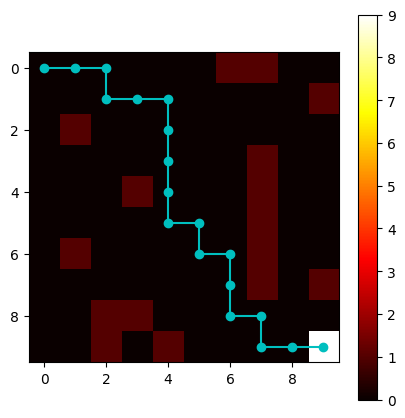

In [26]:
mostrar_ruta_aprendida(laberinto, valores_Q, inicio, meta, tamanio)